# Macro-Economic Time Series Forecasting using SARIMAX

### Installing libraries

In [3]:
!pip install pmdarima pandas-datareader statsmodels

In [4]:
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt


## Preparing Data

In [6]:
start = "1995-01-01"
end = "2025-12-01"

series = {
    "CPI": "CPIAUCSL",
    "FEDFUNDS": "FEDFUNDS",
    "UNRATE": "UNRATE",
    "INDPRO": "INDPRO",
    "OIL": "DCOILWTICO"
}

df = pd.DataFrame()

for name, code in series.items():
    df[name] = pdr.DataReader(code, "fred", start, end)

df = df.dropna()
df.tail()


,CPI,FEDFUNDS,UNRATE,INDPRO,OIL
DATE,,,,,
2025-04-01,320.321,4.33,4.2,101.1279,71.61
2025-05-01,320.580,4.33,4.3,100.9655,60.59
2025-07-01,322.132,4.33,4.3,101.8940,66.64
2025-08-01,323.364,4.33,4.3,101.5867,68.39
2025-12-01,326.030,3.72,4.4,102.3250,59.47


In [7]:
y = df["CPI"]
X = df[["FEDFUNDS", "UNRATE", "INDPRO", "OIL"]]

## Plotting 

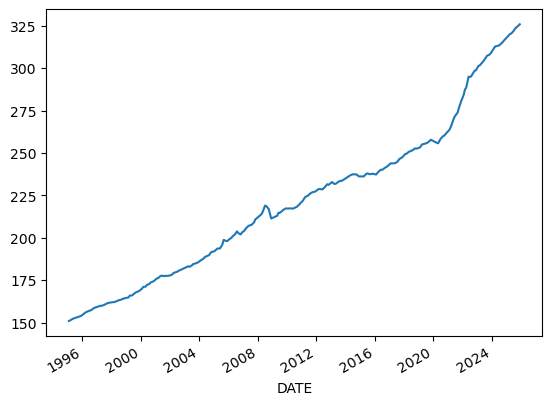

In [9]:
y.plot()
plt.show()

## ADF test to check stationarity

In [11]:
adf_results = adfuller(y)

In [12]:
print(f"test_statistic: {adf_results[0]} \np-value: {round(adf_results[0],2)}")

test_statistic: 2.5009165796371904 
p-value: 2.5


In [13]:
for d in range(1, 4):
    y_diff = y.diff(d).dropna()
    adf_stat, p_value = adfuller(y_diff)[:2]

    print(f"d = {d} | ADF stat = {adf_stat:.4f} | p-value = {p_value:.4f}")

d = 1 | ADF stat = -3.9186 | p-value = 0.0019
d = 2 | ADF stat = -3.1428 | p-value = 0.0235
d = 3 | ADF stat = -2.6116 | p-value = 0.0906


**d = 1 should be fine**

## ACF and PACF to diagnose seasonality

<Figure size 1200x400 with 0 Axes>

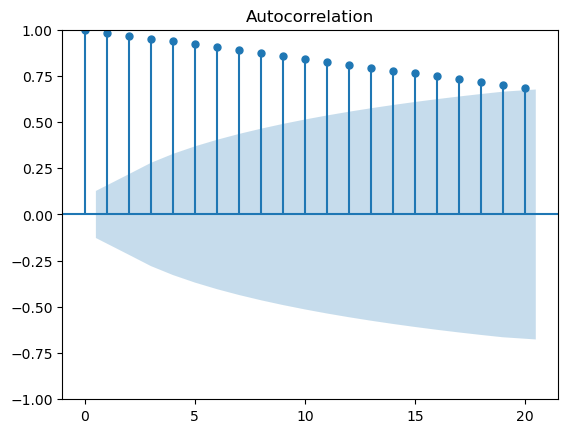

<Figure size 1200x400 with 0 Axes>

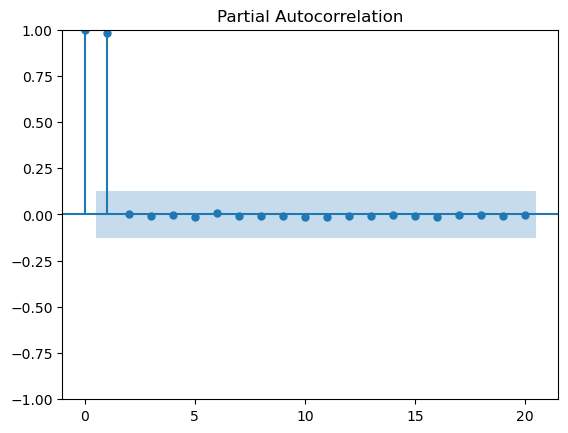

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(y, lags=20)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(y, lags=20)
plt.show()


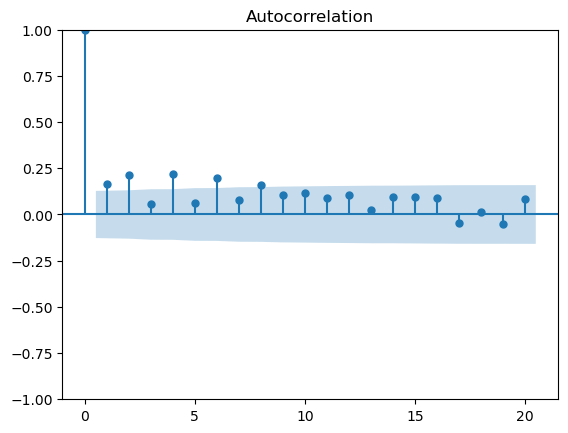

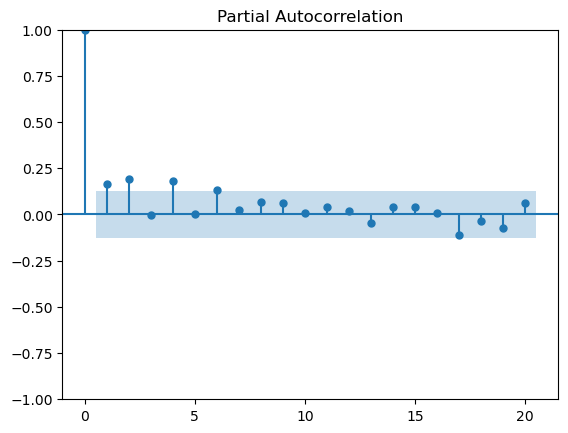

In [17]:
y_diff = y.diff().dropna()

plot_acf(y_diff, lags=20)
plt.show()

plot_pacf(y_diff, lags=20, method='ywm')
plt.show()


**Both ACF and PACF active → mixed AR + MA dynamics**

**non-seasonal ARMA behavior after differencing.**

## ARIMA Model using pm.auto_arima()

In [21]:
arima_model = pm.auto_arima(
    y,
    d=1,
    start_p=1,
    start_q=1,
    seasonal=False,
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    stepwise=True
)

arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=656.197, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=673.693, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=669.189, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=671.099, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=775.241, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=660.619, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=658.163, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=664.720, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=662.025, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=654.108, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=654.431, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=654.181, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=658.990, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=661.570, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=654.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  237
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -321.054
Date:                Wed, 04 Feb 2026   AIC                            654.108
Time:                        12:23:22   BIC                            674.891
Sample:                             0   HQIC                           662.486
                                - 237                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0971      0.080      1.211      0.226      -0.060       0.254
ar.L1         -0.0102      0.085     -0.120      0.905      -0.177       0.156
ar.L2          0.8829      0.092      9.635      0.000       0.703       1.062
ma.L1          0.0746      0.109      0.684      0.494      -0.139       0.288
ma.L2         -0.7200      0.111     -6.498      0.000      -0.937      -0.503
sigma2         0.8879      0.039     22.594      0.000       0.811       0.965
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):              1272.27
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               6.79   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### OBSERVATIONS

Final model

**ARIMA(3,1,3) with intercept**

In [24]:
sarimax = SARIMAX(
    y,
    exog=X,
    order=(3,1,3),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print("Baseline AIC:", 632.82)
print("SARIMAX AIC:", sarimax.aic)


D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Baseline AIC: 632.82
SARIMAX AIC: 504.90075570279373


D:\Users\sujay\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ΔAIC > 10 → very strong improvement

ΔAIC ≈ 100+

**Macro exogenous variables add real, structural explanatory power.**

In [28]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  237
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -241.450
Date:                Wed, 04 Feb 2026   AIC                            504.901
Time:                        12:23:23   BIC                            542.815
Sample:                             0   HQIC                           520.191
                                - 237                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FEDFUNDS      -0.0450      0.150     -0.299      0.765      -0.340       0.250
UNRATE         0.0027      0.112      0.024      0.981      -0.217       0.223
INDPRO        -0.0052      0.051     -0.102      0.918      -0.105       0.095
OIL            0.0806      0.004     19.765      0.000       0.073       0.089
ar.L1          0.3422      0.478      0.715      0.474      -0.595       1.280
ar.L2          0.9298      0.136      6.836      0.000       0.663       1.196
ar.L3         -0.2744      0.423     -0.648      0.517      -1.104       0.555
ma.L1         -0.3547      0.468     -0.757      0.449      -1.272       0.563
ma.L2         -0.7552      0.156     -4.842      0.000      -1.061      -0.449
ma.L3          0.3452      0.310      1.114      0.265      -0.262       0.953
sigma2         0.4672      0.032     14.759      0.000       0.405       0.529
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               199.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               5.39   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting and Plotting 

In [30]:
model = SARIMAX(
    y,
    exog=X,
    order=(3,1,3),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print("AIC:", results.aic)


D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 504.90075570279373


D:\Users\sujay\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
n_steps = 6

X_future = pd.DataFrame(
    np.tile(X.iloc[-1].values, (n_steps, 1)),
    columns=X.columns
)

X_future.index = pd.date_range(
    start=y.index[-1] + pd.offsets.MonthBegin(1),
    periods=n_steps,
    freq="MS"
)


In [32]:
forecast_res = results.get_forecast(
    steps=n_steps,
    exog=X_future
)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()


D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Build future exog (last value carried forward)

In [34]:
n_steps = 6

# Get last observed exog values
last_exog = X.iloc[-1]

# Repeat them for next 6 periods
future_exog = pd.DataFrame(
    np.tile(last_exog.values, (n_steps, 1)),
    columns=X.columns
)


### Dynamic forecast

In [36]:
forecast_res = results.get_forecast(
    steps=n_steps,
    exog=future_exog,
    dynamic=True
)

forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()


D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Users\sujay\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Plot

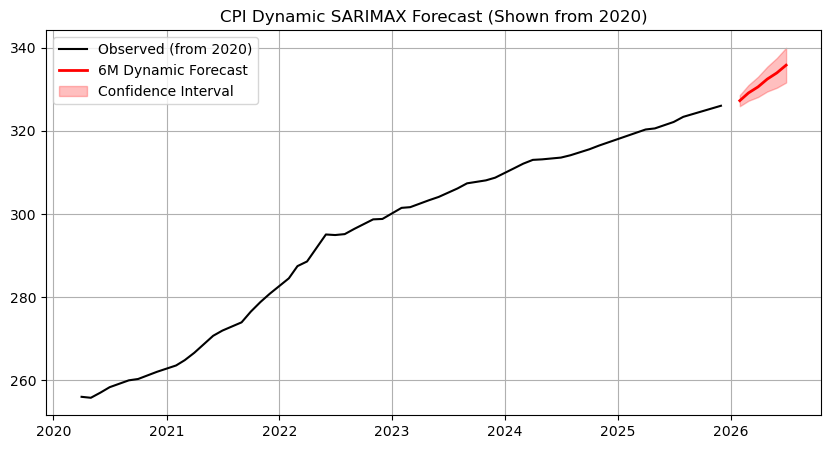

In [38]:
# Slice data from 2020
df_2020 = df.loc['2020-01-01':]

plt.figure(figsize=(10, 5))

# Observed data (from 2020)
plt.plot(
    df_2020.index,
    df_2020['CPI'],
    color='black',
    label='Observed (from 2020)'
)

# Forecast index
forecast_index = pd.date_range(
    start=df.index[-1],
    periods=n_steps + 1,
    freq='M'
)[1:]

# Forecast line
plt.plot(
    forecast_index,
    forecast_mean,
    color='red',
    linewidth=2,
    label='6M Dynamic Forecast'
)

# Confidence interval
plt.fill_between(
    forecast_index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='red',
    alpha=0.25,
    label='Confidence Interval'
)

plt.title('CPI Dynamic SARIMAX Forecast (Shown from 2020)')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
}, index=forecast_index)

forecast_df.round(2)

,Forecast,Lower CI,Upper CI
2026-01-31,327.26,325.92,328.60
2026-02-28,329.11,327.22,330.99
2026-03-31,330.57,328.13,333.01
2026-04-30,332.45,329.47,335.42
2026-05-31,333.94,330.36,337.51
2026-06-30,335.80,331.62,339.97
